In [ ]:
# Install the Kaggle library
!pip install kaggle

# Set up Kaggle API key
import json
import zipfile
import os

# Move kaggle.json to the correct location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the Anime Faces dataset using Kaggle API
!kaggle datasets download -d splcher/animefacedataset

# Unzip the dataset
with zipfile.ZipFile('animefacedataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/animefaces')

# View the unzipped files
!ls /content/animefaces



cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/splcher/animefacedataset
License(s): DbCL-1.0
animefacedataset.zip: Skipping, found more recently modified local copy (use --force to force download)
images


In [ ]:
# List all files and directories in /content
!ls /content




animefacedataset.zip  animefaces  sample_data


In [ ]:
# List all files and directories inside the animefaces folder
!ls /content/animefaces


images


In [ ]:
import os
import random
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from torchvision.utils import save_image

In [ ]:
# Hyperparameters
batch_size = 64
image_size = 64
nz = 100  # Dimension of the noise vector
num_epochs = 50
lr = 0.0002
beta1 = 0.5
num_samples = 5000  # Number of samples to select from the dataset

# Data preprocessing and loading
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])



In [ ]:
# Load the dataset
dataset = datasets.ImageFolder(root='/content/animefaces', transform=transform)

# Randomly select a subset
subset_indices = random.sample(range(len(dataset)), num_samples)
subset = Subset(dataset, subset_indices)
dataloader = DataLoader(subset, batch_size=batch_size, shuffle=True)


In [ ]:
# Define the Generator network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Define the Discriminator network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1)

In [ ]:
# Instantiate models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
netG = Generator().to(device)
netD = Discriminator().to(device)

# Loss function and optimizers
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Train the GAN
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # Update Discriminator
        netD.zero_grad()
        real, _ = data
        input = real.to(device)
        label = torch.full((input.size(0),), 1, dtype=torch.float).to(device)
        output = netD(input)
        errD_real = criterion(output, label)
        errD_real.backward()

        noise = torch.randn(input.size(0), nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(0)
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        optimizerD.step()

        # Update Generator
        netG.zero_grad()
        label.fill_(1)
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        optimizerG.step()

        # Print training status
        print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}] Loss_D: {errD_real+errD_fake:.4f} Loss_G: {errG:.4f}')


[0/50][0/79] Loss_D: 0.0000 Loss_G: 15.6200
[0/50][1/79] Loss_D: 0.1221 Loss_G: 27.6687
[0/50][2/79] Loss_D: 20.4608 Loss_G: 8.0485
[0/50][3/79] Loss_D: 0.2275 Loss_G: 0.6122
[0/50][4/79] Loss_D: 4.4400 Loss_G: 14.2098
[0/50][5/79] Loss_D: 2.7408 Loss_G: 10.9205
[0/50][6/79] Loss_D: 0.0094 Loss_G: 5.0278
[0/50][7/79] Loss_D: 2.4771 Loss_G: 15.3808
[0/50][8/79] Loss_D: 0.1257 Loss_G: 17.3939
[0/50][9/79] Loss_D: 0.1247 Loss_G: 15.6135
[0/50][10/79] Loss_D: 0.0818 Loss_G: 5.9408
[0/50][11/79] Loss_D: 9.5956 Loss_G: 11.8277
[0/50][12/79] Loss_D: 0.4348 Loss_G: 13.6028
[0/50][13/79] Loss_D: 0.4328 Loss_G: 12.9354
[0/50][14/79] Loss_D: 0.1059 Loss_G: 10.1607
[0/50][15/79] Loss_D: 0.1701 Loss_G: 4.9463
[0/50][16/79] Loss_D: 5.3012 Loss_G: 12.5691
[0/50][17/79] Loss_D: 0.8376 Loss_G: 12.2173
[0/50][18/79] Loss_D: 0.4931 Loss_G: 6.2012
[0/50][19/79] Loss_D: 3.0210 Loss_G: 10.7424
[0/50][20/79] Loss_D: 0.2175 Loss_G: 12.3189
[0/50][21/79] Loss_D: 0.3194 Loss_G: 8.7990
[0/50][22/79] Loss_D: 0.35

[0/50][0/79] Loss_D: 0.6875 Loss_G: 14.7694
[0/50][1/79] Loss_D: 0.4816 Loss_G: 13.8741
[0/50][2/79] Loss_D: 0.0831 Loss_G: 11.2226
[0/50][3/79] Loss_D: 0.0104 Loss_G: 8.6268
[0/50][4/79] Loss_D: 0.0237 Loss_G: 6.5888
[0/50][5/79] Loss_D: 0.0397 Loss_G: 5.9148
[0/50][6/79] Loss_D: 0.0483 Loss_G: 6.0165
[0/50][7/79] Loss_D: 0.0901 Loss_G: 6.4223
[0/50][8/79] Loss_D: 0.0490 Loss_G: 6.4316
[0/50][9/79] Loss_D: 0.0182 Loss_G: 7.4665
[0/50][10/79] Loss_D: 0.2003 Loss_G: 7.7604
[0/50][11/79] Loss_D: 0.0710 Loss_G: 9.0092
[0/50][12/79] Loss_D: 0.0979 Loss_G: 6.3437
[0/50][13/79] Loss_D: 0.0793 Loss_G: 5.2895
[0/50][14/79] Loss_D: 0.0328 Loss_G: 6.8419
[0/50][15/79] Loss_D: 0.0201 Loss_G: 5.5101
[0/50][16/79] Loss_D: 0.1146 Loss_G: 5.9334
[0/50][17/79] Loss_D: 0.0585 Loss_G: 5.7801
[0/50][18/79] Loss_D: 0.0460 Loss_G: 5.9078
[0/50][19/79] Loss_D: 0.0552 Loss_G: 6.6008
[0/50][20/79] Loss_D: 0.4189 Loss_G: 11.0172
[0/50][21/79] Loss_D: 0.5024 Loss_G: 10.4627
[0/50][22/79] Loss_D: 0.0161 Loss_G: 

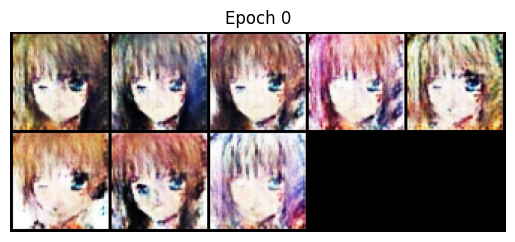

[1/50][0/79] Loss_D: 0.0809 Loss_G: 7.0669
[1/50][1/79] Loss_D: 0.0903 Loss_G: 4.4312
[1/50][2/79] Loss_D: 0.1293 Loss_G: 6.5433
[1/50][3/79] Loss_D: 0.2793 Loss_G: 10.5251
[1/50][4/79] Loss_D: 0.2952 Loss_G: 8.7513
[1/50][5/79] Loss_D: 0.1013 Loss_G: 8.4888
[1/50][6/79] Loss_D: 0.0698 Loss_G: 4.5937
[1/50][7/79] Loss_D: 0.0125 Loss_G: 5.6639
[1/50][8/79] Loss_D: 0.1908 Loss_G: 8.1748
[1/50][9/79] Loss_D: 0.0430 Loss_G: 6.6861
[1/50][10/79] Loss_D: 0.1261 Loss_G: 5.7339
[1/50][11/79] Loss_D: 0.0500 Loss_G: 7.9110
[1/50][12/79] Loss_D: 0.2953 Loss_G: 9.1334
[1/50][13/79] Loss_D: 0.1172 Loss_G: 11.7786
[1/50][14/79] Loss_D: 0.1077 Loss_G: 10.4048
[1/50][15/79] Loss_D: 0.0568 Loss_G: 5.1519
[1/50][16/79] Loss_D: 0.0184 Loss_G: 8.1656
[1/50][17/79] Loss_D: 0.0354 Loss_G: 4.6901
[1/50][18/79] Loss_D: 0.1007 Loss_G: 5.5112
[1/50][19/79] Loss_D: 0.2272 Loss_G: 9.0681
[1/50][20/79] Loss_D: 0.0529 Loss_G: 9.2026
[1/50][21/79] Loss_D: 0.2904 Loss_G: 8.0213
[1/50][22/79] Loss_D: 0.0712 Loss_G: 4.

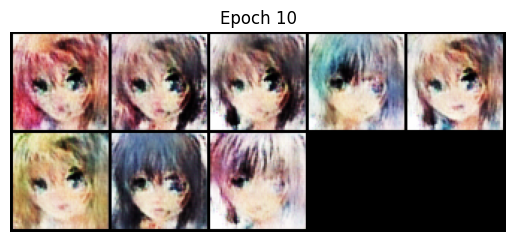

[11/50][0/79] Loss_D: 0.0096 Loss_G: 5.0990
[11/50][1/79] Loss_D: 0.2815 Loss_G: 8.5916
[11/50][2/79] Loss_D: 0.0095 Loss_G: 8.5975
[11/50][3/79] Loss_D: 0.0274 Loss_G: 7.1353
[11/50][4/79] Loss_D: 0.0843 Loss_G: 6.2290
[11/50][5/79] Loss_D: 0.0492 Loss_G: 4.7900
[11/50][6/79] Loss_D: 0.1113 Loss_G: 6.3335
[11/50][7/79] Loss_D: 0.0161 Loss_G: 6.2023
[11/50][8/79] Loss_D: 0.0939 Loss_G: 7.1631
[11/50][9/79] Loss_D: 0.1698 Loss_G: 5.1366
[11/50][10/79] Loss_D: 0.0543 Loss_G: 5.2666
[11/50][11/79] Loss_D: 0.1002 Loss_G: 6.6279
[11/50][12/79] Loss_D: 0.1242 Loss_G: 7.0309
[11/50][13/79] Loss_D: 0.0624 Loss_G: 6.5990
[11/50][14/79] Loss_D: 0.1284 Loss_G: 5.9377
[11/50][15/79] Loss_D: 0.1383 Loss_G: 6.0909
[11/50][16/79] Loss_D: 0.0596 Loss_G: 6.1529
[11/50][17/79] Loss_D: 0.0392 Loss_G: 5.6636
[11/50][18/79] Loss_D: 0.1146 Loss_G: 5.9594
[11/50][19/79] Loss_D: 0.2439 Loss_G: 7.3781
[11/50][20/79] Loss_D: 0.0534 Loss_G: 6.6777
[11/50][21/79] Loss_D: 0.0563 Loss_G: 7.2473
[11/50][22/79] Loss_

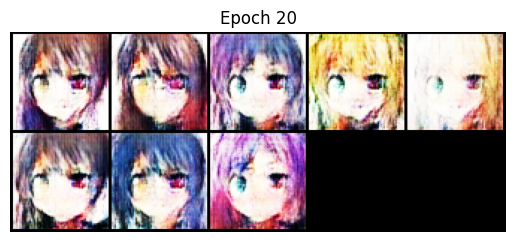

[21/50][0/79] Loss_D: 0.5367 Loss_G: 11.7708
[21/50][1/79] Loss_D: 0.0941 Loss_G: 13.1089
[21/50][2/79] Loss_D: 0.3105 Loss_G: 10.2518
[21/50][3/79] Loss_D: 0.0512 Loss_G: 6.0482
[21/50][4/79] Loss_D: 0.0178 Loss_G: 4.6620
[21/50][5/79] Loss_D: 0.0360 Loss_G: 5.2281
[21/50][6/79] Loss_D: 0.0223 Loss_G: 5.6543
[21/50][7/79] Loss_D: 0.5403 Loss_G: 15.2335
[21/50][8/79] Loss_D: 0.7075 Loss_G: 9.7039
[21/50][9/79] Loss_D: 0.0181 Loss_G: 11.7424
[21/50][10/79] Loss_D: 0.0253 Loss_G: 5.5429
[21/50][11/79] Loss_D: 0.0085 Loss_G: 6.6184
[21/50][12/79] Loss_D: 0.0354 Loss_G: 6.4468
[21/50][13/79] Loss_D: 0.2033 Loss_G: 10.3501
[21/50][14/79] Loss_D: 0.0541 Loss_G: 8.1564
[21/50][15/79] Loss_D: 0.1003 Loss_G: 8.8212
[21/50][16/79] Loss_D: 0.0340 Loss_G: 6.7844
[21/50][17/79] Loss_D: 0.0503 Loss_G: 5.0624
[21/50][18/79] Loss_D: 0.0359 Loss_G: 5.0098
[21/50][19/79] Loss_D: 0.4931 Loss_G: 14.3718
[21/50][20/79] Loss_D: 0.7232 Loss_G: 10.5330
[21/50][21/79] Loss_D: 0.0467 Loss_G: 10.3728
[21/50][22/

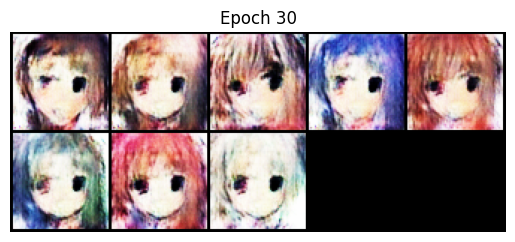

[31/50][0/79] Loss_D: 0.0477 Loss_G: 7.0224
[31/50][1/79] Loss_D: 0.0703 Loss_G: 6.1788
[31/50][2/79] Loss_D: 0.2784 Loss_G: 9.5546
[31/50][3/79] Loss_D: 0.1201 Loss_G: 8.0326
[31/50][4/79] Loss_D: 0.2870 Loss_G: 5.2419
[31/50][5/79] Loss_D: 0.0334 Loss_G: 4.6917
[31/50][6/79] Loss_D: 0.3784 Loss_G: 11.8884
[31/50][7/79] Loss_D: 0.0225 Loss_G: 12.3210
[31/50][8/79] Loss_D: 0.2597 Loss_G: 10.2731
[31/50][9/79] Loss_D: 0.0306 Loss_G: 7.2089
[31/50][10/79] Loss_D: 0.0178 Loss_G: 6.4498
[31/50][11/79] Loss_D: 0.0666 Loss_G: 5.8520
[31/50][12/79] Loss_D: 0.0157 Loss_G: 6.4389
[31/50][13/79] Loss_D: 0.0486 Loss_G: 5.6253
[31/50][14/79] Loss_D: 0.0162 Loss_G: 6.0013
[31/50][15/79] Loss_D: 0.0890 Loss_G: 6.4324
[31/50][16/79] Loss_D: 0.0434 Loss_G: 7.5712
[31/50][17/79] Loss_D: 0.0479 Loss_G: 5.8675
[31/50][18/79] Loss_D: 0.1152 Loss_G: 5.4093
[31/50][19/79] Loss_D: 0.1158 Loss_G: 6.3725
[31/50][20/79] Loss_D: 0.0783 Loss_G: 5.8449
[31/50][21/79] Loss_D: 0.2076 Loss_G: 4.0305
[31/50][22/79] Lo

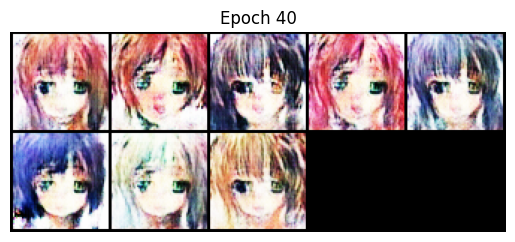

[41/50][0/79] Loss_D: 0.1066 Loss_G: 7.5443
[41/50][1/79] Loss_D: 0.0042 Loss_G: 10.4289
[41/50][2/79] Loss_D: 0.0200 Loss_G: 7.7054
[41/50][3/79] Loss_D: 0.0032 Loss_G: 9.1966
[41/50][4/79] Loss_D: 0.0388 Loss_G: 6.3439
[41/50][5/79] Loss_D: 0.0149 Loss_G: 7.1047
[41/50][6/79] Loss_D: 0.0143 Loss_G: 7.6804
[41/50][7/79] Loss_D: 0.1704 Loss_G: 8.8501
[41/50][8/79] Loss_D: 0.0648 Loss_G: 10.0570
[41/50][9/79] Loss_D: 0.1166 Loss_G: 12.7532
[41/50][10/79] Loss_D: 0.0327 Loss_G: 6.7033
[41/50][11/79] Loss_D: 0.0193 Loss_G: 6.3805
[41/50][12/79] Loss_D: 0.0222 Loss_G: 6.5028
[41/50][13/79] Loss_D: 0.6401 Loss_G: 18.4405
[41/50][14/79] Loss_D: 1.6209 Loss_G: 12.0073
[41/50][15/79] Loss_D: 0.0043 Loss_G: 7.9176
[41/50][16/79] Loss_D: 0.0017 Loss_G: 7.4988
[41/50][17/79] Loss_D: 0.5363 Loss_G: 14.4659
[41/50][18/79] Loss_D: 0.0173 Loss_G: 16.6720
[41/50][19/79] Loss_D: 0.1064 Loss_G: 15.0254
[41/50][20/79] Loss_D: 0.0869 Loss_G: 10.0862
[41/50][21/79] Loss_D: 0.0245 Loss_G: 6.7715
[41/50][22/

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from torchvision.utils import make_grid, save_image

# Define a function to display generated images
def show_generated_images(fake_images, epoch):
    # Denormalize [-1, 1] -> [0, 1]
    fake_images = (fake_images + 1) / 2
    grid = make_grid(fake_images, nrow=5, normalize=True)
    npimg = grid.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.title(f'Epoch {epoch}')
    plt.show()


# Train the GAN
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # Update Discriminator
        netD.zero_grad()
        real, _ = data
        input = real.to(device)
        label = torch.full((input.size(0),), 1, dtype=torch.float).to(device)
        output = netD(input)
        errD_real = criterion(output, label)
        errD_real.backward()

        noise = torch.randn(input.size(0), nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(0)
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        optimizerD.step()

        # Update Generator
        netG.zero_grad()
        label.fill_(1)
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        optimizerG.step()

        # Print training status
        print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}] Loss_D: {errD_real+errD_fake:.4f} Loss_G: {errG:.4f}')

    # Save and show generated images every 10 epochs
    if epoch % 10 == 0:
        save_image(fake.data[:25], f'anime_faces_epoch_{epoch}.png', nrow=5, normalize=True)
        show_generated_images(fake.data[:25], epoch)

# Save models after training
torch.save(netG.state_dict(), 'generator.pth')
torch.save(netD.state_dict(), 'discriminator.pth')
